In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive berhasil di-mount.
Path Konten: /content/drive/MyDrive/Deep Learning/Tugas 3/merak-putih-03.jpg
Path Style: /content/drive/MyDrive/Deep Learning/Tugas 3/download batik.jpg


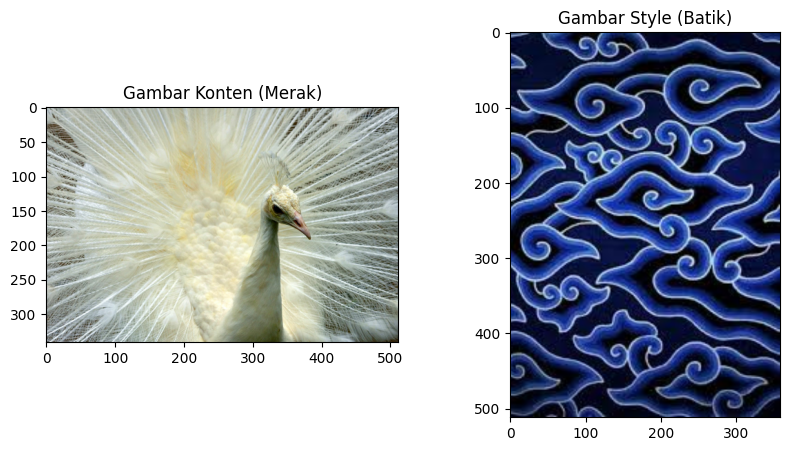

Mulai proses training style transfer...
....................................................................................................
Epoch: 1/10


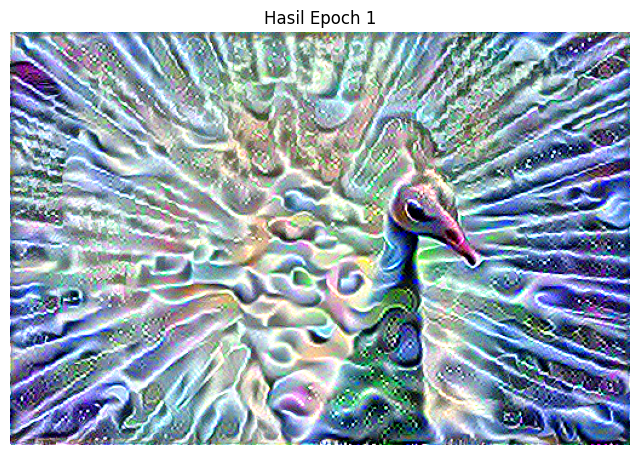

....................................................................................................
Epoch: 2/10


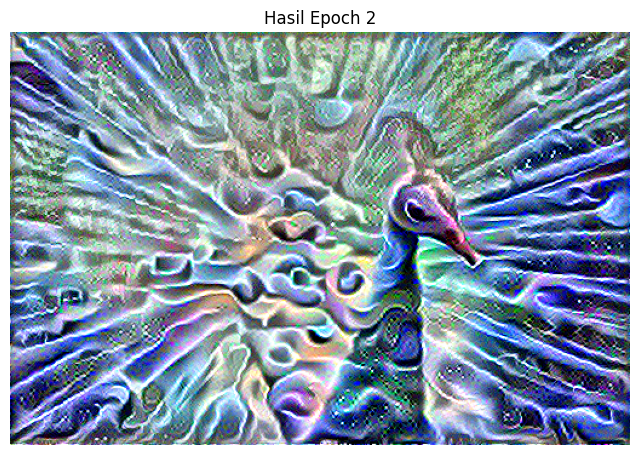

....................................................................................................
Epoch: 3/10


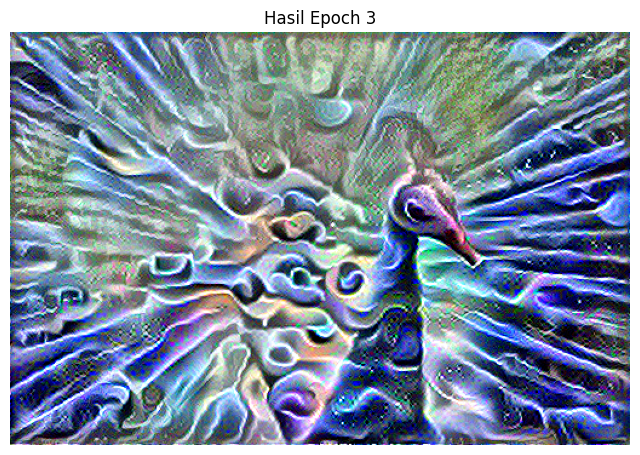

....................................................................................................
Epoch: 4/10


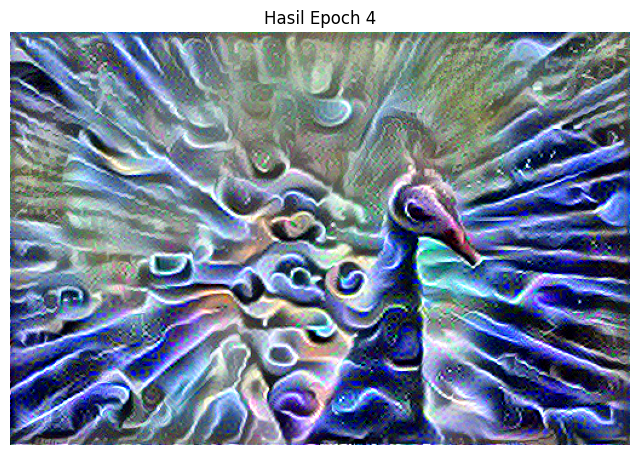

....................................................................................................
Epoch: 5/10


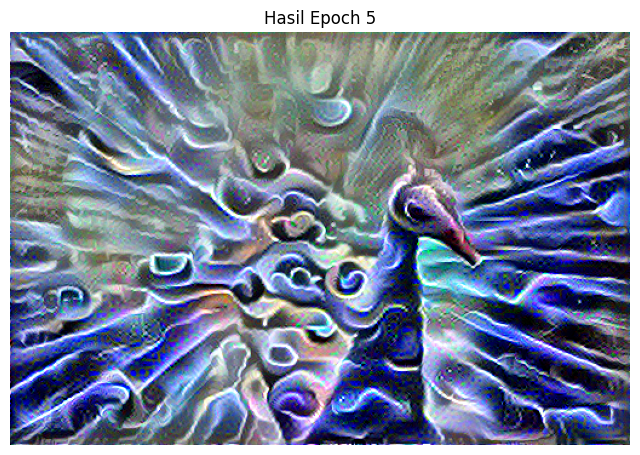

....................................................................................................
Epoch: 6/10


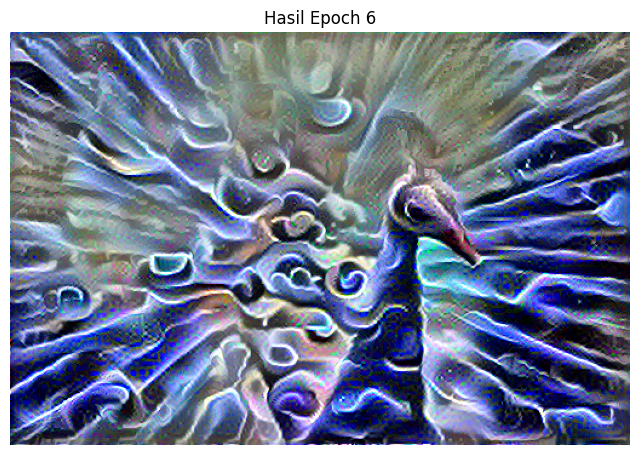

....................................................................................................
Epoch: 7/10


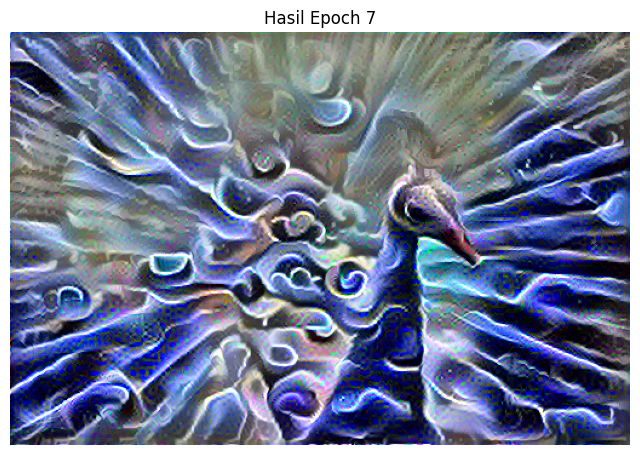

....................................................................................................
Epoch: 8/10


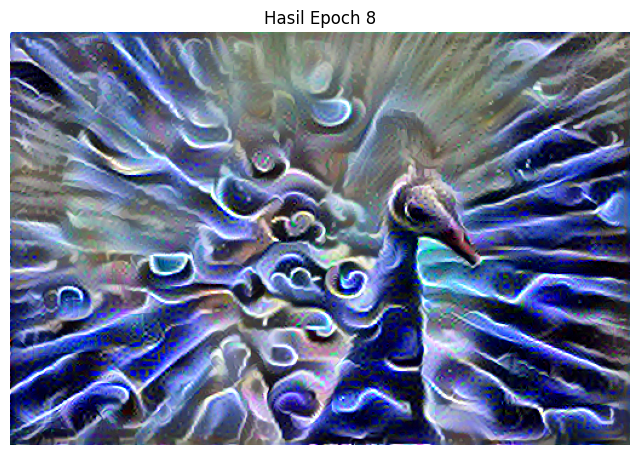

....................................................................................................
Epoch: 9/10


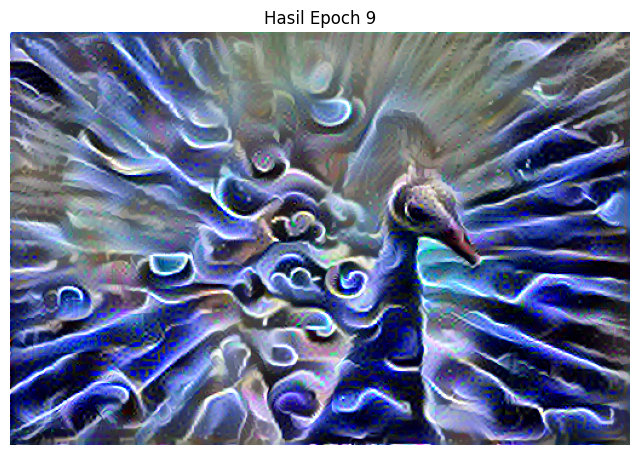

....................................................................................................
Epoch: 10/10


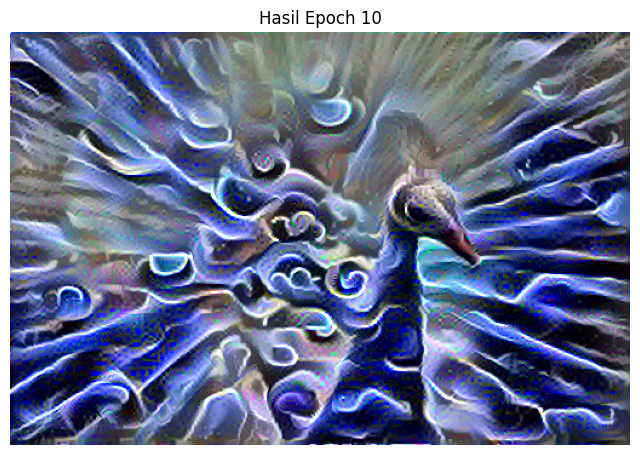

Total waktu: 7828.0 detik
Gambar berhasil disimpan di: /content/drive/MyDrive/Deep Learning/Tugas 3/hasil_harimau_batik.png


In [4]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import functools
from google.colab import drive

# 1. Mount Google Drive (PENTING: Jalankan ini agar Colab bisa membaca file kamu)
# Kamu akan diminta login ke akun Google saat bagian ini dijalankan
try:
    drive.mount('/content/drive')
    print("Google Drive berhasil di-mount.")
except:
    print("Drive mungkin sudah di-mount atau terjadi kesalahan.")

# 2. Konfigurasi Path Gambar (Sesuai request kamu)
# Pastikan file benar-benar ada di lokasi ini di Google Drive kamu
content_path = '/content/drive/MyDrive/Deep Learning/Tugas 3/merak-putih-03.jpg'
style_path = '/content/drive/MyDrive/Deep Learning/Tugas 3/download batik.jpg'

print(f"Path Konten: {content_path}")
print(f"Path Style: {style_path}")

# 3. Fungsi Utilitas untuk Memuat dan Memproses Gambar
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

# 4. Memuat Gambar
try:
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(content_image, 'Gambar Konten (Merak)')
    plt.subplot(1, 2, 2)
    imshow(style_image, 'Gambar Style (Batik)')
    plt.show()
except Exception as e:
    print(f"Error memuat gambar: {e}")
    print("Pastikan path file sudah benar dan file ada di Google Drive.")

# 5. Membangun Model (VGG19)
# Kita menggunakan VGG19 tapi hanya mengambil layer tertentu untuk style dan konten
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Layer untuk representasi style (tekstur/pola)
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
# Layer untuk representasi konten (bentuk objek)
content_layers = ['block5_conv2']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # Input gambar harus berupa float [0,1] lalu dikonversi ke format VGG (0-255)
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

# Fungsi Gram Matrix (Kunci dari Style Transfer)
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

# 6. Setup Training
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Gambar awal adalah gambar konten (bisa juga noise random, tapi ini lebih cepat)
image = tf.Variable(content_image)

# Fungsi Loss Total
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Bobot (Weight) - Bisa diubah untuk mengatur seberapa kuat efek batik vs harimau asli
    style_weight = 1e-2  # Perbesar ini agar batik lebih dominan
    content_weight = 1e4 # Perbesar ini agar bentuk harimau lebih jelas

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

# Optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Fungsi satu langkah training (Train Step)
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

        # Variational Loss untuk mengurangi noise pixel yang kasar
        total_variation_weight = 30
        loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

# 7. Eksekusi Training (Loop Utama)
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

print("Mulai proses training style transfer...")

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(f".", end='', flush=True)

    # Tampilkan hasil setiap epoch
    print(f"\nEpoch: {n+1}/{epochs}")
    plt.figure(figsize=(8, 8))
    imshow(image, title=f'Hasil Epoch {n+1}')
    plt.axis('off')
    plt.show()

end = time.time()
print(f"Total waktu: {end-start:.1f} detik")

# 8. Simpan Hasil Akhir
file_name = 'hasil_harimau_batik.png'
save_path = f'/content/drive/MyDrive/Deep Learning/Tugas 3/{file_name}'

# Konversi tensor ke image PIL dan simpan
tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
tensor = PIL.Image.fromarray(tensor)
tensor.save(save_path)

print(f"Gambar berhasil disimpan di: {save_path}")